# RO change over time

## Imports

In [1]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xarray as xr
import tqdm
import pathlib
import cmocean

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## Functions

## Load data

In [2]:
## MPI data
mpi_load_fp = pathlib.Path("/Users/theo/research/enso2025_xro/data/mpi_Th/Th.nc")
Th = xr.open_dataset(mpi_load_fp)

## Look at parameter change over time

Next, define a function to compute parameter changes over time

In [3]:
def get_ensemble_params_over_time(
    data, T_var="T_3", h_var="h_w", window_size=360, step_size=60
):
    """Get RO params for each ensemble member as a function of time.
    Args:
        window_size: size of sliding window (units: months)
        step_size: how many months to slide the window between each calculation
    """

    ## Get number of timesteps in data
    n = len(data.time)

    ## empty list to hold results and dates
    params_by_year = []
    start_dates = []

    ## loop through rolling windows
    for i in tqdm.tqdm(np.arange(0, n - step_size, step_size)):

        ## make sure there's enough samples for robust estimate
        if (n - i) > (0.7 * window_size):

            ## get subset of data for fitting model
            data_subset = data.isel(time=slice(i, i + window_size))

            ## Get start date for subset
            start_dates.append(data_subset.time.isel(time=0))

            ## get parameter fit
            params_by_year.append(
                get_ensemble_params(
                    data_subset, T_var=T_var, h_var=h_var, verbose=False
                )
            )

    ## convert from list to xarray
    start_dates = xr.concat(start_dates, dim="time")
    params_by_year = xr.concat(params_by_year, dim=start_dates)

    return params_by_year

### Do the computation and save parameters to file

In [4]:
## specify save filepath
save_fp = pathlib.Path("/Users/theo/research/enso2025_xro/results/params.nc")

## Load parameters if already computed
if save_fp.is_file():
    params = xr.open_dataset(save_fp)

else:
    ## compute params
    params = get_ensemble_params_over_time(Th, window_size=360, step_size=60)

    ## save to file
    params.to_netcdf(save_fp)

### Plot diagnostics

#### Ensemble-mean growth rate as a function of seasonal cycle and time

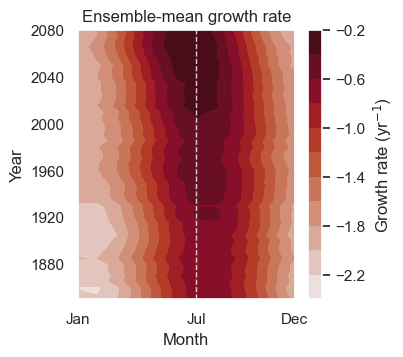

In [5]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

## plot data
cp = ax.contourf(
    params.cycle, params.time, params["BJ_ac"].mean("member"), cmap="cmo.amp", levels=10
)

## set ticks and add guideline
ax.set_xticks([1, 7, 12], labels=["Jan", "Jul", "Dec"])
ax.axvline(7, c="w", ls="--", lw=1, alpha=0.8)

## add colorbar
cb = fig.colorbar(cp, label=r"Growth rate (yr$^{-1}$)")

## label
ax.set_title("Ensemble-mean growth rate")
ax.set_xlabel("Month")
ax.set_ylabel("Year")

plt.show()

#### Plot annual max growth rate

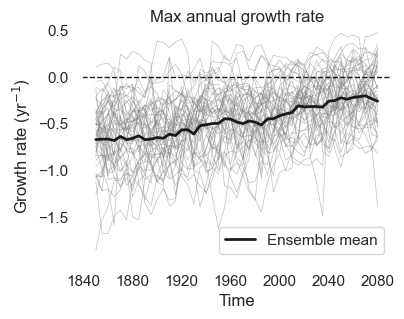

In [6]:
fig, ax = plt.subplots(figsize=(4, 3))

## plot ensemble members
for i, m in enumerate(params.member.values):

    label = "Ensemble members" if (i == 50) else None

    ax.plot(
        params.time,
        params["BJ_ac"].sel(member=m).max("cycle"),
        c="gray",
        alpha=0.5,
        lw=0.5,
    )

## plot ensemble mean
ax.plot(
    params.time,
    params["BJ_ac"].mean("member").max("cycle"),
    c="k",
    lw=2,
    label="Ensemble mean",
)

## add labels and set plot style
ax.axhline(0, c="k", ls="--", lw=1)
ax.set_ylim([None, 0.5])
ax.set_xlabel("Time")
ax.set_ylabel(r"Growth rate (yr$^{-1}$)")
ax.set_title("Max annual growth rate")
ax.legend()

plt.show()